In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import copy
import seaborn as sns
warnings.filterwarnings("ignore")

In [2]:
file_path = '/kaggle/input/wadi-data/'

In [3]:
df_raw = pd.read_csv(file_path + 'WADI_14days_new.csv')
df = df_raw.iloc[:,3:]

In [4]:
atk_raw = pd.read_csv(file_path + 'WADI_attackdataLABLE.csv')
atk = atk_raw.iloc[:-2,3:]

In [5]:
new_header = atk.iloc[0]
atk = atk[1:].reset_index(drop=True)
atk.columns = new_header

In [6]:
cols_to_drop = [47, 48, 83, 84]

dropped_df = df.drop(df.columns[cols_to_drop], axis=1)
dropped_atk = atk.drop(atk.columns[cols_to_drop], axis=1)


In [7]:
dropped_df.fillna(method='bfill', inplace=True)

In [8]:
sum(dropped_df.isna().sum())

0

In [9]:
dropped_atk.drop(columns=['2B_AIT_002_PV'], inplace=True)

In [10]:
dropped_df.drop(columns=['2B_AIT_002_PV'], inplace=True)

In [11]:
dropped_atk

,1_AIT_001_PV,1_AIT_002_PV,1_AIT_003_PV,1_AIT_004_PV,1_AIT_005_PV,1_FIT_001_PV,1_LS_001_AL,1_LS_002_AL,1_LT_001_PV,1_MV_001_STATUS,...,3_MV_002_STATUS,3_MV_003_STATUS,3_P_001_STATUS,3_P_002_STATUS,3_P_003_STATUS,3_P_004_STATUS,LEAK_DIFF_PRESSURE,PLANT_START_STOP_LOG,TOTAL_CONS_REQUIRED_FLOW,"Attack LABLE (1:No Attack, -1:Attack)"
0,164.21,0.529486,11.9972,482.48,0.331167,0.00127323,0,0,48.482,1,...,1,1,1,1,1,1,62.6226,1,0.39,1
1,164.21,0.529486,11.9972,482.48,0.331167,0.00127323,0,0,48.482,1,...,1,1,1,1,1,1,62.6226,1,0.39,1
2,164.21,0.529486,11.9972,482.48,0.331167,0.00127323,0,0,48.482,1,...,1,1,1,1,1,1,62.6226,1,0.39,1
3,164.21,0.529486,11.9972,482.48,0.331167,0.00127323,0,0,48.482,1,...,1,1,1,1,1,1,62.6226,1,0.39,1
4,164.21,0.529486,11.9972,482.48,0.331167,0.00127323,0,0,48.482,1,...,1,1,1,1,1,1,62.6226,1,0.39,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172796,172.959,0.547483,11.9184,466.034,0.318217,0.001222,0.0,0.0,55.5587,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,59.3546,1.0,0.0,1
172797,172.959,0.547483,11.9184,466.034,0.318217,0.001222,0.0,0.0,55.5587,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,59.3546,1.0,0.0,1
172798,172.915,0.583479,11.9211,466.051,0.318317,0.00126,0.0,0.0,55.726,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,58.8102,1.0,0.0,1
172799,172.915,0.583479,11.9211,466.051,0.318317,0.00126,0.0,0.0,55.726,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,58.8102,1.0,0.0,1


In [12]:
dropped_df.shape

(784571, 122)

In [13]:
N_SAMPLES = len(dropped_df)  # Number of total time series samples
N_TIMESTEPS = 30  # Length of each time series sequence
N_FEATURES = 122   # Number of features in the multivariate series
ANOMALY_FRACTION = 0.1 # Percentage of data that will be anomalous
ANOMALY_MAGNITUDE = 6
HIDDEN_DIM_LSTM_1 = 128 # LSTM units for first encoder/decoder layer
HIDDEN_DIM_LSTM_2 = 64  # LSTM units for second encoder/decoder layer (bottleneck representation)
LEARNING_RATE = 1e-3
EPOCHS = 200 # Increase for potentially better performance, watch for overfitting
BATCH_SIZE = 64
THRESHOLD_PERCENTILE = 95
PATIENCE = 5

In [14]:
def build_dataset(data, window_size=N_TIMESTEPS, step=10):
    X = []
    for i in range(0, len(data) - window_size + 1, step):
        window = data.iloc[i : i + window_size, :]
        X.append(window.values)
    return np.array(X)

In [15]:
train = build_dataset(dropped_df)

In [16]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, n_features, n_timesteps, hidden_dim_lstm_1, hidden_dim_lstm_2):
        super(LSTMAutoencoder, self).__init__()
        self.n_features = n_features
        self.n_timesteps = n_timesteps
        self.hidden_dim_lstm_1 = hidden_dim_lstm_1
        self.hidden_dim_lstm_2 = hidden_dim_lstm_2 # This will be our bottleneck dimension

        # Encoder
        self.encoder_lstm1 = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_dim_lstm_1,
            num_layers=1,
            batch_first=True # Expects (batch, seq, feature)
        )
        self.encoder_lstm2 = nn.LSTM(
            input_size=hidden_dim_lstm_1,
            hidden_size=hidden_dim_lstm_2, # Bottleneck
            num_layers=1,
            batch_first=True
        )

        # Decoder
        self.decoder_lstm1 = nn.LSTM(
            input_size=hidden_dim_lstm_2, # From bottleneck
            hidden_size=hidden_dim_lstm_1,
            num_layers=1,
            batch_first=True
        )
        self.decoder_lstm2 = nn.LSTM(
            input_size=hidden_dim_lstm_1,
            hidden_size=n_features, # Output original number of features
            num_layers=1,
            batch_first=True
        )
        # A linear layer to ensure output matches input feature dim precisely if LSTM output isn't directly features
        # However, setting last LSTM hidden_size to n_features often works.
        # If you want to be explicit or apply activation like sigmoid:
        self.output_fc = nn.Linear(n_features, n_features) # Or hidden_dim_lstm_1 if decoder_lstm2 outputs that
        self.sigmoid = nn.Sigmoid() # Since data is scaled to 0-1

    def forward(self, x):
        # x shape: (batch_size, n_timesteps, n_features)

        # Encoder
        # LSTM output: (output_seq, (h_n, c_n))
        # We are interested in the output sequence from the first LSTM
        # and the final hidden state (or output sequence) from the bottleneck LSTM
        encoded_seq1, _ = self.encoder_lstm1(x)
        encoded_seq2, (hidden_n, cell_n) = self.encoder_lstm2(encoded_seq1)
        # encoded_seq2 is (batch, seq_len, hidden_dim_lstm_2)
        # The last output of the sequence from the bottleneck LSTM can act as the latent representation
        # Or, more commonly for sequence-to-sequence, the entire output sequence `encoded_seq2` is used.
        # For a more "bottlenecked" representation, one might take only the last hidden state `hidden_n`.
        # Let's use the full output sequence of the bottleneck layer.

        # Decoder
        # The input to the decoder should be the "context" or "bottleneck" representation.
        # We can feed the `encoded_seq2` (output sequence of bottleneck LSTM) directly.
        decoded_seq1, _ = self.decoder_lstm1(encoded_seq2)
        decoded_seq2, _ = self.decoder_lstm2(decoded_seq1)
        # decoded_seq2 is (batch, seq_len, n_features)

        reconstructed = self.output_fc(decoded_seq2) # Pass through final linear layer
        reconstructed = self.sigmoid(reconstructed) # Apply sigmoid for 0-1 range

        return reconstructed


In [17]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [18]:
model = LSTMAutoencoder(
    N_FEATURES, N_TIMESTEPS, HIDDEN_DIM_LSTM_1, HIDDEN_DIM_LSTM_2).to(DEVICE)
print("\nModel Architecture:")
print(model)

criterion = nn.MSELoss(reduction='none') # Use 'none' to get per-element loss for detailed error calculation
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


Model Architecture:
LSTMAutoencoder(
  (encoder_lstm1): LSTM(122, 128, batch_first=True)
  (encoder_lstm2): LSTM(128, 64, batch_first=True)
  (decoder_lstm1): LSTM(64, 128, batch_first=True)
  (decoder_lstm2): LSTM(128, 122, batch_first=True)
  (output_fc): Linear(in_features=122, out_features=122, bias=True)
  (sigmoid): Sigmoid()
)


In [19]:
X_train_normal_np, X_val_normal_np = train_test_split(
    train, test_size=0.2, random_state=42
)

In [20]:
X_train_normal_np.shape

(62764, 30, 122)

In [21]:
scalers = [MinMaxScaler(feature_range=(0,1)) for _ in range(N_FEATURES)]

In [22]:
temp_train_data_for_scaling = X_train_normal_np.reshape(-1, N_FEATURES)
for i in range(N_FEATURES):
    scalers[i].fit(temp_train_data_for_scaling[:, i].reshape(-1, 1))

In [23]:
def scale_data_sequences(sequences_np, scalers_list):
    scaled_sequences = np.zeros_like(sequences_np)
    for i in range(N_FEATURES):
        # Reshape feature column for all samples and timesteps, scale, then reshape back
        feature_col_flat = sequences_np[:, :, i].reshape(-1, 1)
        scaled_feature_col_flat = scalers_list[i].transform(feature_col_flat)
        scaled_sequences[:, :, i] = scaled_feature_col_flat.reshape(sequences_np.shape[0], N_TIMESTEPS)
    return scaled_sequences

In [24]:
X_test_sequences = dropped_atk.iloc[:,:-1]
y_test_anomaly_sequences_np = np.array(dropped_atk.iloc[:,-1]).astype(float)
X_test_sequences_np = build_dataset(X_test_sequences)

In [25]:
X_test_sequences_np = X_test_sequences_np.astype(float)

In [26]:
len(dropped_atk)

172801

In [27]:
X_test_sequences_np.shape

(17278, 30, 122)

In [28]:
X_train_scaled_np = scale_data_sequences(X_train_normal_np, scalers)
X_val_scaled_np = scale_data_sequences(X_val_normal_np, scalers)
X_test_scaled_np = scale_data_sequences(X_test_sequences_np, scalers)

In [29]:
X_test_sequences_np.shape

(17278, 30, 122)

In [30]:
X_train_tensor = torch.tensor(X_train_scaled_np, dtype=torch.float32).to(DEVICE)
X_val_tensor = torch.tensor(X_val_scaled_np, dtype=torch.float32).to(DEVICE)
X_test_tensor = torch.tensor(X_test_scaled_np, dtype=torch.float32).to(DEVICE)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

val_dataset = TensorDataset(X_val_tensor, X_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Test loader for final evaluation on data from FILE_PATH_2
# The "target" for the autoencoder is still the input sequence itself for calculating reconstruction error.
# The y_test_anomaly_sequences_np will be used for performance metrics.
test_dataset = TensorDataset(X_test_tensor, X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [31]:
train_epoch_losses = []
val_epoch_losses = []

best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None # To store the state of the best model

print("\nStarting Training...")
for epoch in range(EPOCHS):
    model.train()
    running_train_loss = 0.0
    for sequences, _ in train_loader:
        sequences = sequences.to(DEVICE)
        optimizer.zero_grad()
        reconstructed = model(sequences)
        loss_elements = criterion(reconstructed, sequences)
        loss_batch = torch.mean(loss_elements)
        loss_batch.backward()
        optimizer.step()
        running_train_loss += loss_batch.item() * sequences.size(0)
    
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_epoch_losses.append(epoch_train_loss)

    model.eval()
    running_val_loss = 0.0
    current_epoch_val_loss_value = float('nan')


    with torch.no_grad():
        for sequences, _ in val_loader:
            sequences = sequences.to(DEVICE)
            reconstructed = model(sequences)
            loss_elements = criterion(reconstructed, sequences)
            loss_batch = torch.mean(loss_elements)
            running_val_loss += loss_batch.item() * sequences.size(0)
    
    current_epoch_val_loss_value = running_val_loss / len(val_loader.dataset)
    val_epoch_losses.append(current_epoch_val_loss_value)

    # Early Stopping Check
    if current_epoch_val_loss_value < best_val_loss:
        best_val_loss = current_epoch_val_loss_value
        epochs_no_improve = 0
        # Save the best model state
        best_model_state = copy.deepcopy(model.state_dict())
        print(f"Epoch {epoch+1}: Validation loss improved to {best_val_loss:.6f}. Saving model state.")
    else:
        epochs_no_improve += 1
        print(f"Epoch {epoch+1}: Validation loss ({current_epoch_val_loss_value:.6f}) did not improve from best ({best_val_loss:.6f}). Patience: {epochs_no_improve}/{PATIENCE}.")


    if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == EPOCHS -1 or epochs_no_improve == 0 : # Print more often if improving
        print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {epoch_train_loss:.6f}, Val Loss: {current_epoch_val_loss_value:.6f}")
    
    if epochs_no_improve >= PATIENCE:
        print(f"\nEarly stopping triggered after {epoch + 1} epochs as validation loss did not improve for {PATIENCE} epochs.")
        if best_model_state:
            print("Loading best model state.")
            model.load_state_dict(best_model_state) # Load the best model found
        break

# After training loop (either completed all epochs or early stopped)
if best_model_state and epochs_no_improve >= PATIENCE : # If early stopping was triggered
    pass # Model is already loaded with best_model_state
elif best_model_state : # If training finished but best_model_state was captured (e.g. last epoch was best)
    model.load_state_dict(best_model_state)
else:
    print("Training finished.")



Starting Training...
Epoch 1: Validation loss improved to 0.034839. Saving model state.
Epoch 1/200, Train Loss: 0.037040, Val Loss: 0.034839
Epoch 2: Validation loss (0.034899) did not improve from best (0.034839). Patience: 1/5.
Epoch 3: Validation loss improved to 0.011935. Saving model state.
Epoch 3/200, Train Loss: 0.022850, Val Loss: 0.011935
Epoch 4: Validation loss improved to 0.007117. Saving model state.
Epoch 4/200, Train Loss: 0.009063, Val Loss: 0.007117
Epoch 5: Validation loss improved to 0.004558. Saving model state.
Epoch 5/200, Train Loss: 0.005922, Val Loss: 0.004558
Epoch 6: Validation loss improved to 0.003284. Saving model state.
Epoch 6/200, Train Loss: 0.003858, Val Loss: 0.003284
Epoch 7: Validation loss improved to 0.002227. Saving model state.
Epoch 7/200, Train Loss: 0.002771, Val Loss: 0.002227
Epoch 8: Validation loss improved to 0.001695. Saving model state.
Epoch 8/200, Train Loss: 0.002086, Val Loss: 0.001695
Epoch 9: Validation loss improved to 0.001

In [32]:
save_path = "best.pth"
torch.save(model.state_dict(), save_path)

In [33]:
# state_dict = torch.load('/kaggle/input/lstm_autoencoder/pytorch/lstm/2/best.pth', map_location=DEVICE)
# model.load_state_dict(state_dict)

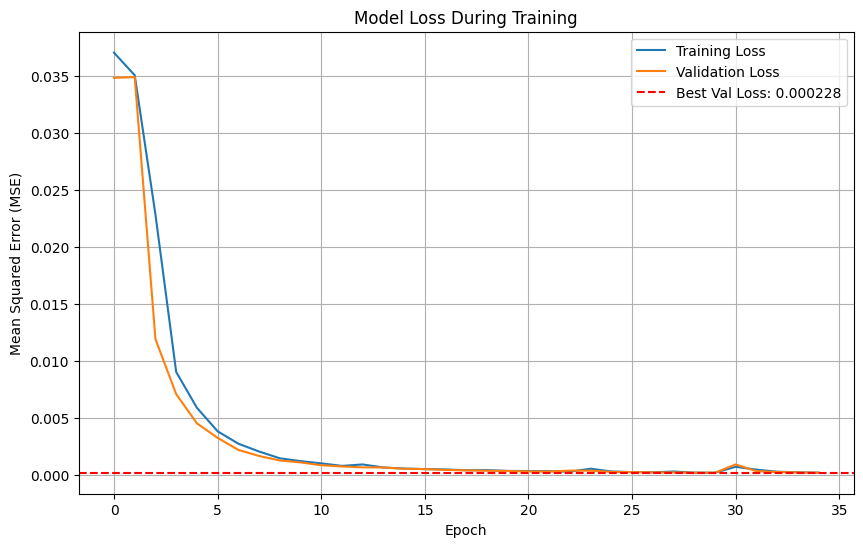

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(train_epoch_losses, label='Training Loss')
plt.plot(val_epoch_losses, label='Validation Loss')
plt.title('Model Loss During Training')
plt.ylabel('Mean Squared Error (MSE)')
plt.xlabel('Epoch')
plt.axhline(y=best_val_loss, color='r', linestyle='--', label=f'Best Val Loss: {best_val_loss:.6f}')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
model.eval()

val_normal_reconstruction_errors = []
with torch.no_grad():
    for sequences, _ in val_loader:
        sequences = sequences.to(DEVICE)
        reconstructed = model(sequences)
        loss_elements = criterion(reconstructed, sequences)
        errors_per_sample = torch.mean(loss_elements, dim=[1, 2])
        val_normal_reconstruction_errors.extend(errors_per_sample.cpu().numpy())

In [36]:
errors_per_sample.shape

torch.Size([11])

In [37]:
mse_val_normal_np = np.array(val_normal_reconstruction_errors)
anomaly_threshold = np.percentile(mse_val_normal_np, 95)
print(f"\nAnomaly Threshold ({THRESHOLD_PERCENTILE}th percentile of normal validation MSE): {anomaly_threshold:.6f}")


Anomaly Threshold (95th percentile of normal validation MSE): 0.000829


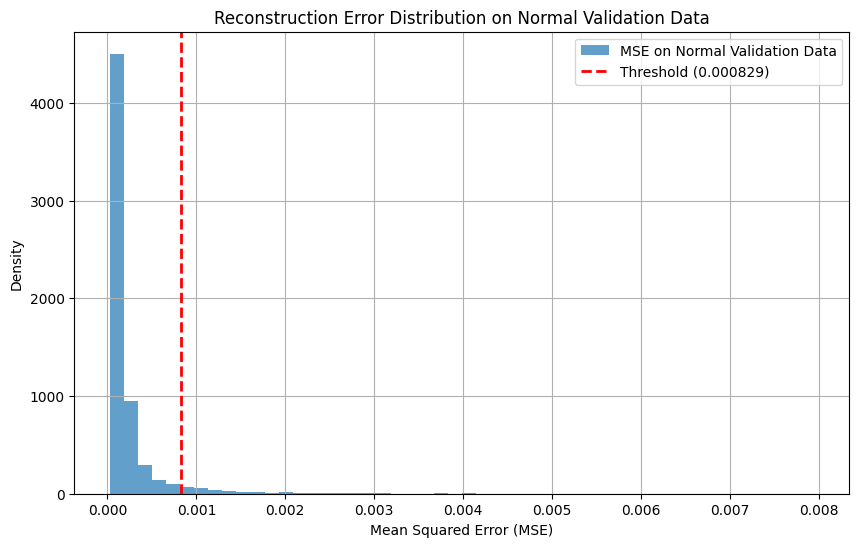

In [38]:
plt.figure(figsize=(10, 6))
plt.hist(mse_val_normal_np, bins=50, label='MSE on Normal Validation Data', alpha=0.7, density=True)
plt.axvline(anomaly_threshold, color='r', linestyle='dashed', linewidth=2, label=f'Threshold ({anomaly_threshold:.6f})')
plt.title('Reconstruction Error Distribution on Normal Validation Data')
plt.xlabel('Mean Squared Error (MSE)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
def create_labels_for_sequences(original_point_labels, n_timesteps, num_sequences, step_size):
    if original_point_labels is None or num_sequences == 0:
        return np.zeros(num_sequences, dtype=int)

    y_sequence_labels = np.zeros(num_sequences, dtype=int)
    for i in range(num_sequences):
        actual_start_index_in_raw = i * step_size
        if actual_start_index_in_raw + n_timesteps <= len(original_point_labels):
            if np.any(original_point_labels[actual_start_index_in_raw : actual_start_index_in_raw + n_timesteps] == 1):
                y_sequence_labels[i] = 1
        else:
            print(f"Warning: Trying to access labels out of bounds for sequence index {i}. Raw start: {actual_start_index_in_raw}, Label length: {len(original_point_labels)}")
    return y_sequence_labels

In [40]:
y_test_sequence_labels_np = create_labels_for_sequences(
            y_test_anomaly_sequences_np, N_TIMESTEPS, X_test_sequences_np.shape[0], 10
        )

In [41]:
y_test_raw_point_labels_np = y_test_anomaly_sequences_np

In [42]:
test_data_sequence_errors = []
test_data_reconstructed_sequences_list = []
original_test_sequences_for_plot_list = []

with torch.no_grad():
    for sequences, _ in test_loader:
        sequences = sequences.to(DEVICE)
        reconstructed = model(sequences)
        loss_elements = criterion(reconstructed, sequences)
        errors_per_sample = torch.mean(loss_elements, dim=[1, 2])
        test_data_sequence_errors.extend(errors_per_sample.cpu().numpy())
        test_data_reconstructed_sequences_list.append(reconstructed.cpu().numpy())
        original_test_sequences_for_plot_list.append(sequences.cpu().numpy())

mse_test_sequences_np = np.array(test_data_sequence_errors)

pointwise_error_sum = np.zeros(len(dropped_df))
pointwise_error_count = np.zeros(len(dropped_df))

for seq_idx in range(len(X_test_sequences_np)):
    sequence_error = mse_test_sequences_np[seq_idx]
    raw_start_idx = seq_idx * 10
    for point_offset in range(N_TIMESTEPS):
        point_idx_in_raw = raw_start_idx + point_offset
        if point_idx_in_raw < len(dropped_df):
            pointwise_error_sum[point_idx_in_raw] += sequence_error
            pointwise_error_count[point_idx_in_raw] += 1
        else:
            break

averaged_pointwise_errors = np.zeros_like(pointwise_error_sum)
non_zero_counts_mask = pointwise_error_count > 0
averaged_pointwise_errors[non_zero_counts_mask] = pointwise_error_sum[non_zero_counts_mask] / pointwise_error_count[non_zero_counts_mask]

y_predict_pointwise = (averaged_pointwise_errors > anomaly_threshold).astype(int)

final_y_true_pointwise = y_test_raw_point_labels_np[:len(y_predict_pointwise)]
final_y_predict_pointwise = y_predict_pointwise[:len(y_test_raw_point_labels_np)]

final_y_true_pointwise[final_y_true_pointwise == 1] = 0

final_y_true_pointwise[final_y_true_pointwise == -1] = 1

print(f"\n--- Point-wise Anomaly Detection Results ---")
print(f"Number of true point-wise anomalies in test dataset: {np.sum(final_y_true_pointwise == 1)}")
print(f"Number of predicted point-wise anomalies in test dataset: {np.sum(final_y_predict_pointwise == 1)}")

if (np.any(final_y_true_pointwise == 0) or np.any(final_y_true_pointwise == 1)) and \
   (np.any(final_y_predict_pointwise == 0) or np.any(final_y_predict_pointwise == 1)):
    from sklearn.metrics import classification_report, confusion_matrix, f1_score
    print("\nPoint-wise Classification Report on Test Dataset:")
    print(classification_report(final_y_true_pointwise, final_y_predict_pointwise, target_names=['Normal', 'Anomaly'], labels=[0, 1], zero_division=0))


--- Point-wise Anomaly Detection Results ---
Number of true point-wise anomalies in test dataset: 9977
Number of predicted point-wise anomalies in test dataset: 62010

Point-wise Classification Report on Test Dataset:
              precision    recall  f1-score   support

      Normal       0.98      0.67      0.80    162824
     Anomaly       0.13      0.81      0.23      9977

    accuracy                           0.68    172801
   macro avg       0.56      0.74      0.51    172801
weighted avg       0.93      0.68      0.76    172801



In [43]:
y_true = final_y_true_pointwise.astype(int)
y_pred = final_y_predict_pointwise.astype(int)

In [44]:
np.unique(y_pred)

array([0, 1])

Accuracy	 0.677461357283812
Precision	 0.13104338009998387
Recall	 0.8144732885636965
f1 score	 0.22576298498339978
cohen_kappa_score	 0.1402431143050935
auc	 0.74176963696106
roc_auc	 0.74176963696106


Text(0.5, 23.52222222222222, 'Ground Truth')

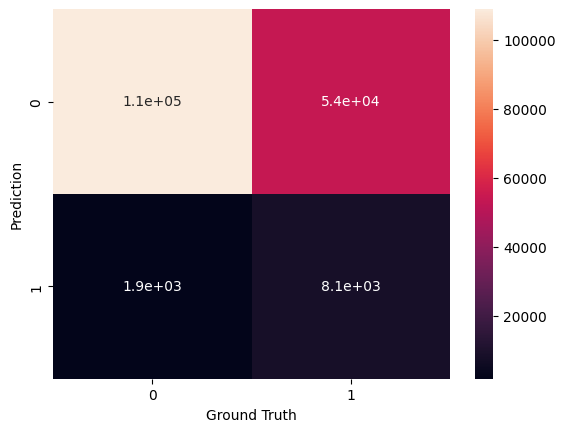

In [45]:
import seaborn as sns
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
accuracy = (tp + tn) / (tn + fp + fn + tp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = (2 * precision * recall)/ (precision + recall)
cohen_kappa_score = cohen_kappa_score(y_true, y_pred)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, y_pred)
auc_val = auc(false_positive_rate, true_positive_rate)
roc_auc_val = roc_auc_score(y_true, y_pred)

print('Accuracy\t', accuracy)
print('Precision\t', precision)
print('Recall\t', recall)
print('f1 score\t', f1_score)
print('cohen_kappa_score\t', cohen_kappa_score)
print('auc\t', auc_val)
print('roc_auc\t', roc_auc_val)

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)
plt.ylabel('Prediction')
plt.xlabel('Ground Truth')